In [1]:
import joblib

# Preprocessing
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Torch-related
import torch
from pytorch_model_summary import summary

# Custom defined
from libs.raw_data import *
from libs.dataset import *
from architecture.architecture import *

device = torch.device("cuda")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
is_test_mode = False
mode = "pre-train"
mode = "fine_tuning"

# Raw data
is_prep_data_exist = True

# Data loader
MIN_MEANINGFUL_SEQ_LEN = 100
MAX_SEQ_LEN = 100
PRED_LEN = 50

modality_info = {
    "group": ["article_id", "sales_channel_id"],
    "target": ["sales"],
    "temporal": ["day", "dow", "month", "holiday", "price"],
    "img": ["img_path"],
    "nlp": []
}
processing_info = {
    "scaling_cols": {"sales": StandardScaler, "price": StandardScaler},
    "embedding_cols": ["day","dow", "month", "holiday"],
    "img_cols": ["img_path"],
    "nlp_cols": []
}

# Model
batch_size = 16
target_batch_size = 32
num_accm = int(target_batch_size//batch_size)
nhead = 4
dropout = 0.1
patch_size = 16

d_model = {"encoder":256, "decoder":128}
d_ff = {"encoder":256, "decoder":128}
num_layers = {"encoder":2, "decoder":2}
remain_rto = {"temporal":1., "img":1., "nlp":1.}

In [3]:
data_info = DataInfo(modality_info, processing_info)
df_prep = get_raw_data(is_test_mode, is_prep_data_exist)

df_valid = df_prep[(df_prep["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN)
                    &(df_prep["time_idx"] <= MAX_SEQ_LEN-1+PRED_LEN)
                    &(~pd.isna(df_prep["detail_desc"]))]

In [4]:
path = './saved_model_epoch0_2024-05-01 16:38:44.025989'

label_encoder_dict = joblib.load("./src/label_encoder_dict.pkl")
mbae = MaskedBlockAutoEncoder(data_info, label_encoder_dict,
                            d_model, num_layers, nhead, d_ff, dropout, "gelu",
                            patch_size)
mbae.load_state_dict(torch.load(path))
mbae_encoder = mbae.mbae_encoder
mbae_encoder.to(device)
""

In [ ]:
from tqdm import tqdm; tqdm.pandas()

# Sklearn-related
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

# Torch-related
import torch
from transformers import AutoImageProcessor, AutoTokenizer
from PIL import Image

# transform_img = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
transform_img = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization parameters for ImageNet
    transforms.Normalize(mean=[0.7623358, 0.74334157, 0.738284], std=[0.27400097, 0.2852157, 0.28155997])
])
augmentation = transforms.Compose([
    # transforms.Resize((224,224)),
    transforms.RandomResizedCrop((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # transforms.RandomRotation(45),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization parameters for ImageNet
    transforms.Normalize(mean=[0.7623358, 0.74334157, 0.738284], std=[0.27400097, 0.2852157, 0.28155997])
])

class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, data, data_info, remain_rto, label_encoder_dict):
        super().__init__()
        self.data_info, self.remain_rto = data_info, remain_rto
        self.tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

        # Fit label encoder
        self.label_encoder_dict = label_encoder_dict

        # Iterate data
        data_li = []
        data.groupby(self.data_info.modality_info["group"]).progress_apply(lambda x: data_li.append(x))
        self.dataset = tuple(data_li)

    def transform_label_encoder(self, data):
        result_dict = {}
        embedding_cols = self.data_info.processing_info["embedding_cols"]
        for col in embedding_cols:
            result_dict[col] = self.label_encoder_dict[col].transform(data[col].values)
        return result_dict
    
    def scale_data(self, data):
        result_dict = {}
        scaling_cols = self.data_info.processing_info["scaling_cols"]
        for col, scaler in scaling_cols.items():
            scaler = scaler()
            result_dict[col] = scaler.fit_transform(data[col].values.reshape(-1,1))
            result_dict[f"{col}_scaler"] = scaler
        return result_dict

    def apply_nlp_remain(self, data):
        result_dict = {}
        nlp_cols = self.data_info.modality_info["nlp"]
        remain_rto = self.remain_rto["nlp"]

        for col in nlp_cols:
            nlp_data = set(data[col].values); assert len(nlp_data) == 1
            total_token = self.tokenizer(next(iter(nlp_data)), return_tensors="np")["input_ids"].squeeze()
            
            # Split global token and valid token
            global_token = total_token[:1]
            valid_token = total_token[1:]
            
            # Get remain/masked/revert indices
            valid_token_shape = valid_token.shape; assert len(valid_token_shape)==1
            
            num_remain = int(valid_token_shape[0] * remain_rto)
            noise = np.random.rand(valid_token_shape[0])
            shuffle_idx = np.argsort(noise)
            
            remain_idx = shuffle_idx[:num_remain]
            masked_idx = shuffle_idx[num_remain:]
            revert_idx = np.argsort(shuffle_idx)
            
            remain_padding_mask = np.ones(remain_idx.shape[0]+1)
            masked_padding_mask = np.ones(masked_idx.shape[0]+1)
            revert_padding_mask = np.ones(revert_idx.shape[0]+1)

            result_dict.update({f"{col}":total_token, f"{col}_raw":nlp_data,
                                f"{col}_remain_idx":remain_idx, f"{col}_masked_idx":masked_idx, f"{col}_revert_idx":revert_idx,
                                f"{col}_remain_padding_mask":remain_padding_mask, f"{col}_masked_padding_mask":masked_padding_mask, f"{col}_revert_padding_mask":revert_padding_mask})

        return result_dict

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        result_dict = {}
        data = self.dataset[idx]
        
        # Laben encode and scale data
        embedding_cols = self.transform_label_encoder(data)
        scaling_cols = self.scale_data(data)
        result_dict.update(**embedding_cols, **scaling_cols)
        
        # Temporal forecast/padding mask
        target_col = self.data_info.modality_info["target"]
        target_fcst_mask = np.ones(data[target_col].shape).squeeze()
        target_fcst_mask[-PRED_LEN:] = 0
        
        temporal_padding_mask  = np.ones(data[target_col].shape).squeeze()
        result_dict.update({"target_fcst_mask":target_fcst_mask, "temporal_padding_mask":temporal_padding_mask})

        # Img
        img_cols = self.data_info.modality_info["img"]
        for col in img_cols:
            img_path = set(data[col].values); assert len(img_path) == 1
            img_raw = Image.open(next(iter(img_path))).convert("RGB")
            result_dict[f"{col}_raw"] = img_raw
        
        # Nlp
        nlp_result_dict = self.apply_nlp_remain(data)
        result_dict.update(nlp_result_dict)

        return result_dict

def valid_collate_fn(batch_li, data_info):
    result_dict = {}
    # Temporal
    target_temporal_cols = data_info.modality_info["target"] + data_info.modality_info["temporal"]
    for col in target_temporal_cols:
        tensor_type = torch.int if col in data_info.processing_info["embedding_cols"] else torch.float
        data = [torch.from_numpy(batch[col]).to(tensor_type) for batch in batch_li]
        result_dict[col] = torch.nn.utils.rnn.pad_sequence(data, batch_first=True)
    ### Temporal masks
    target_fcst_mask = [torch.from_numpy(batch["target_fcst_mask"]) for batch in batch_li]
    temporal_padding_mask = [torch.from_numpy(batch["temporal_padding_mask"]) for batch in batch_li]
    
    result_dict["target_fcst_mask"] = torch.nn.utils.rnn.pad_sequence(target_fcst_mask, batch_first=True)
    result_dict["temporal_padding_mask"] = torch.nn.utils.rnn.pad_sequence(temporal_padding_mask, batch_first=True)

    # Img
    img_cols = data_info.modality_info["img"]
    for col in img_cols:
        img_raw = [batch[f"{col}_raw"] for batch in batch_li]
        img_data = torch.stack([augmentation(i) for i in img_raw], dim=0)

        result_dict[f"{col}_raw"] = torch.stack([transform_img(i) for i in img_raw], dim=0)
        result_dict[f"{col}"] = img_data
    
    # Nlp
    nlp_cols = data_info.modality_info["nlp"]
    for col in nlp_cols:
        data = [torch.from_numpy(batch[col]).to(torch.int) for batch in batch_li]
        data_remain_idx = [torch.from_numpy(batch[f"{col}_remain_idx"]).to(torch.int64) for batch in batch_li]
        data_masked_idx = [torch.from_numpy(batch[f"{col}_masked_idx"]).to(torch.int64) for batch in batch_li]
        data_revert_idx = [torch.from_numpy(batch[f"{col}_revert_idx"]).to(torch.int64) for batch in batch_li]
        data_remain_padding_mask = [torch.from_numpy(batch[f"{col}_remain_padding_mask"]).to(tensor_type) for batch in batch_li]
        data_masked_padding_mask = [torch.from_numpy(batch[f"{col}_masked_padding_mask"]).to(tensor_type) for batch in batch_li]
        data_revert_padding_mask = [torch.from_numpy(batch[f"{col}_revert_padding_mask"]).to(tensor_type) for batch in batch_li]

        result_dict[col] = torch.nn.utils.rnn.pad_sequence(data, batch_first=True)
        result_dict[f"{col}_remain_idx"] = torch.nn.utils.rnn.pad_sequence(data_remain_idx, batch_first=True)
        result_dict[f"{col}_masked_idx"] = torch.nn.utils.rnn.pad_sequence(data_masked_idx, batch_first=True)
        result_dict[f"{col}_revert_idx"] = torch.nn.utils.rnn.pad_sequence(data_revert_idx, batch_first=True)
        result_dict[f"{col}_remain_padding_mask"] = torch.nn.utils.rnn.pad_sequence(data_remain_padding_mask, batch_first=True)
        result_dict[f"{col}_masked_padding_mask"] = torch.nn.utils.rnn.pad_sequence(data_masked_padding_mask, batch_first=True)
        result_dict[f"{col}_revert_padding_mask"] = torch.nn.utils.rnn.pad_sequence(data_revert_padding_mask, batch_first=True)

        result_dict[f"{col}_raw"] = [batch[f"{col}_raw"] for batch in batch_li]

    return result_dict

1==1

True

In [ ]:
valid_dataset = ValidDataset(df_valid, data_info, remain_rto, label_encoder_dict)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: valid_collate_fn(x, data_info), pin_memory=True, num_workers=16, prefetch_factor=4)
for valid_data in valid_dataloader:
    [print(key, val.shape) for key, val in valid_data.items() if "scaler" not in key and "raw" not in key]
    break

100%|██████████| 112213/112213 [00:03<00:00, 29396.73it/s]


sales torch.Size([16, 150, 1])
day torch.Size([16, 150])
dow torch.Size([16, 150])
month torch.Size([16, 150])
holiday torch.Size([16, 150])
price torch.Size([16, 150, 1])
target_fcst_mask torch.Size([16, 150])
temporal_padding_mask torch.Size([16, 150])
img_path torch.Size([16, 3, 224, 224])


In [ ]:
class GlobalDecoder(torch.nn.Module):
    def __init__(self, temporal_cols, img_cols, nlp_cols, d_model, nhead, d_ff, dropout, activation, num_layers):
        super().__init__()
        self.temporal_cols, self.img_cols, self.nlp_cols = temporal_cols, img_cols, nlp_cols
        self.decoder_layer = torch.nn.ModuleList([DecoderLayer(d_model, nhead, d_ff, dropout, activation) for _ in range(num_layers)])
    
    def forward(self, data_dict, padding_mask_dict, device):
        tgt_dict, tgt_key_padding_mask_dict, memory_dict, memory_key_padding_mask_dict= self.get_tgt_memory(data_dict, padding_mask_dict, device)
        for mod in self.decoder_layer:
                tgt_dict, self_attn_weight, cross_attn_weight_dict, _ = mod(tgt_dict, memory_dict, tgt_key_padding_mask_dict, memory_key_padding_mask_dict, fine_tuning=True)
        decoding_dict = {"global":tgt_dict["temporal"]}
        return decoding_dict, self_attn_weight, cross_attn_weight_dict
    
    def get_tgt_memory(self, data_dict, padding_mask_dict, device):
        tgt_dict, tgt_key_padding_mask_dict, memory_dict, memory_key_padding_mask_dict = {}, {}, {}, {}
        modality = "temporal"

        # Obtain target
        tgt_dict[modality] = data_dict["global"]
    
        tgt_key_padding_mask_dict[modality] = padding_mask_dict["temporal_padding_mask"]
        assert tgt_dict[modality].shape[:-1] == tgt_key_padding_mask_dict[modality].shape
        
        # Memory
        ### Temporal memory
        temporal_memory_li = [val for key, val in data_dict.items() if key in ["global"] + self.temporal_cols]
        temporal_memory_block = torch.stack(temporal_memory_li, dim=-2)
        memory_dict["temporal"] = temporal_memory_block

        num_modality = temporal_memory_block.shape[-2]

        temporal_key_padding_mask = padding_mask_dict["temporal_padding_mask"].unsqueeze(-1).repeat(1, 1, num_modality)
        # temporal_key_padding_mask = torch.ones(padding_mask_dict["temporal_padding_mask"].shape).unsqueeze(-1).repeat(1, 1, num_modality).to(device)
        temporal_key_padding_mask[:, :, 1] = padding_mask_dict["target_fcst_mask"]

        memory_key_padding_mask_dict["temporal"] = temporal_key_padding_mask
        assert temporal_memory_block.shape[:-1] == temporal_key_padding_mask.shape

        ### Static memory
        static_memory_li = [val for key, val in data_dict.items() if key in self.img_cols+self.nlp_cols]
        if len(static_memory_li) > 0:
            static_memory = torch.cat(static_memory_li, dim=1)
            memory_dict["static"] = static_memory
            
            static_key_padding_mask_li = [padding_mask_dict[f"{key}_revert_padding_mask"] for key in data_dict.keys() if key in self.img_cols+self.nlp_cols]
            static_key_padding_mask = torch.cat(static_key_padding_mask_li, dim=1)
            memory_key_padding_mask_dict["static"] = static_key_padding_mask
            assert static_memory.shape[:-1] == static_key_padding_mask.shape

        return tgt_dict, tgt_key_padding_mask_dict, memory_dict, memory_key_padding_mask_dict


In [ ]:
class ForecasterDecoder(torch.nn.Module):
    def __init__(self, temporal_cols, img_cols, nlp_cols,\
                        d_model_from, d_model, num_layers, nhead, d_ff, dropout, activation):
        super().__init__()
        self.temporal_cols, self.img_cols, self.nlp_cols = temporal_cols, img_cols, nlp_cols
        # 8. Decoding
        self.global_decoder = GlobalDecoder(temporal_cols, img_cols, nlp_cols, d_model, nhead, d_ff, dropout, activation, num_layers)
        self.norm = torch.nn.LayerNorm(d_model)
        # 9. Output
        self.output = Output(data_info, d_model, nhead, d_ff, dropout, activation, num_layers, label_encoder_dict, ["global"]+temporal_cols, img_cols, nlp_cols, patch_size)
    
    def forward(self, posmod_emb_dict,
                    idx_dict, padding_mask_dict):
        # 8. Decoding
        decoding_dict, self_attn_weight, cross_attn_weight_dict = self.global_decoder(posmod_emb_dict, padding_mask_dict, device)

        # 9. Output
        output_dict = self.output(decoding_dict, padding_mask_dict)

        return output_dict["global"], self_attn_weight, cross_attn_weight_dict

In [ ]:
class Forecaster(torch.nn.Module):
    def __init__(self, data_info, mbae_encoder,\
                    d_model, num_layers, nhead, d_ff, dropout, activation):
        super().__init__()
        temporal_cols, img_cols, nlp_cols = self.define_col_modalities(data_info)
        self.temporal_cols, self.img_cols, self.nlp_cols = temporal_cols, img_cols, nlp_cols
        self.mbae_encoder = mbae_encoder
        self.forecaster_decoder = ForecasterDecoder(temporal_cols, img_cols, nlp_cols, d_model["encoder"], d_model["decoder"], num_layers["decoder"], nhead, d_ff["decoder"], dropout, activation)
        
        # self.encoder = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model["decoder"], nhead, d_ff["decoder"], dropout, activation, batch_first=True, norm_first=True), num_layers["decoder"])
        # self.linear = torch.nn.Linear(d_model["decoder"], 1)
    
    def forward(self, data_input, remain_rto, device):
        data_input["sales"] = torch.where(data_input["target_fcst_mask"].unsqueeze(-1)==1, data_input["sales"], 0)
        posmod_emb_dict,\
                encoding_weight_dict, data_dict, idx_dict, padding_mask_dict = self.mbae_encoder(data_input, remain_rto, device)
        
        decoding, self_attn_weight, cross_attn_weight_dict = self.forecaster_decoder(posmod_emb_dict,\
                                                                                    idx_dict, padding_mask_dict)
        
        # decoding = self.encoder(posmod_emb_dict["global"])
        # decoding = self.linear(decoding)
        # self_attn_weight = None
        # encoding_weight_dict["temporal"] = encoding_weight_dict["temporal"][:, :, :, 0, :]
    
        return decoding, self_attn_weight, cross_attn_weight_dict, data_dict, idx_dict, padding_mask_dict
        # return decoding, self_attn_weight, encoding_weight_dict, data_dict, idx_dict, padding_mask_dict
    
    def define_col_modalities(self, data_info):
        temporal_cols = data_info.modality_info["target"] + data_info.modality_info["temporal"]
        img_cols = data_info.modality_info["img"]
        nlp_cols = data_info.modality_info["nlp"]

        return temporal_cols, img_cols, nlp_cols


model = Forecaster(data_info, mbae_encoder,\
                    d_model, num_layers, nhead, d_ff, dropout, "gelu")
model.to(device)
summary(model, valid_data, remain_rto, device, show_parent_layers=True, print_summary=True)
""

-------------------------------------------------------------------------------------------
   Parent Layers           Layer (type)        Output Shape         Param #     Tr. Param #
      Forecaster          MBAEEncoder-1                          87,432,320      87,432,320
      Forecaster    ForecasterDecoder-2        [16, 150, 1]       2,167,622       2,167,622
Total params: 89,599,942
Trainable params: 89,599,942
Non-trainable params: 0
-------------------------------------------------------------------------------------------


''

In [ ]:
for name, param in model.named_parameters():
    # if "img_model" in name:
    #     param.requires_grad = False
    # elif "nlp_model" in name:
    #     param.requires_grad = False
    
    if "forecaster_decoder" in name:
        param.requires_grad = False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


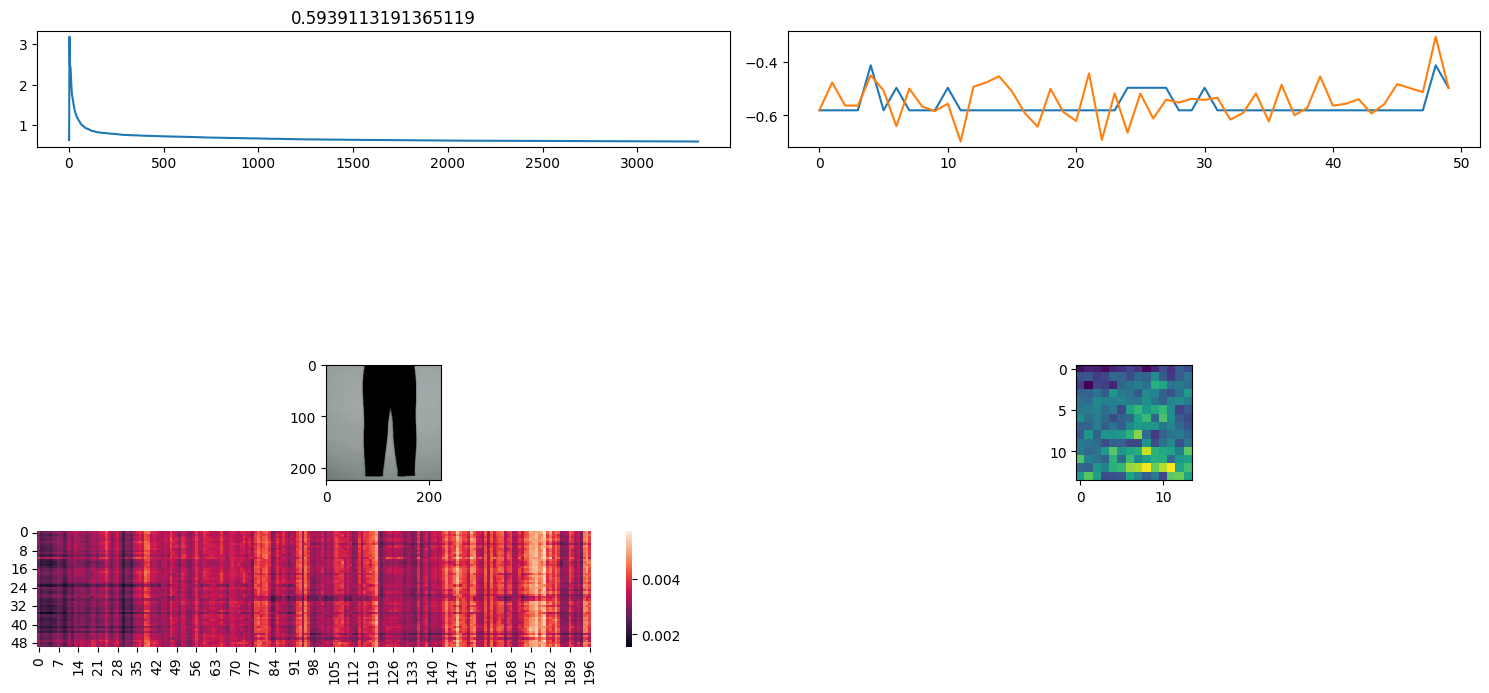

 48%|████▊     | 3340/7014 [10:36<10:41,  5.73it/s]

In [ ]:
from tqdm import tqdm; tqdm.pandas()
from collections import defaultdict
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")

import copy

def train(e):
    pbar = tqdm(valid_dataloader)
    loss_li, mean_loss_li = [], []
    accm_idx = 0

    for n, data in enumerate(pbar):
        # Train
        optimizer.zero_grad()
        model.train()
        output, self_attn_weight, cross_attn_weight_dict, data_dict, idx_dict, padding_mask_dict = model(copy.deepcopy(data), remain_rto, device)

        loss = mse_loss(output.squeeze(), data["sales"].to(device).squeeze())
        mask = torch.where((padding_mask_dict["temporal_padding_mask"].squeeze()==1)&(padding_mask_dict["target_fcst_mask"].squeeze()==0), 1, 0)

        loss *= mask
        loss = loss.sum() / mask.sum()
        loss_li.append(loss.item())
        mean_loss_li.append(np.array(loss_li).mean())
        
        accm_idx += 1
        (loss/accm_idx).backward()
        
        if accm_idx == num_accm:
            optimizer.step()
            accm_idx = 0

        # Plot
        if n % 20 == 0:
            nrows, ncols, idx = 30, 2, 0
            plt.figure(figsize=(15, 50))
            clear_output(wait=True)
            
            # Loss
            plt.subplot(nrows, ncols, 1)
            plt.plot(mean_loss_li)
            plt.title(mean_loss_li[-1])

            # Sample
            plt.subplot(nrows, ncols, 2)
            pred = torch.where(mask==1, output.squeeze(), torch.nan)[idx]
            pred = pred[~torch.isnan(pred)]
            y = torch.where(mask==1, data["sales"].to(device).squeeze(), torch.nan)[idx]
            y = y[~torch.isnan(y)]

            plt.plot(y.squeeze().detach().cpu())
            plt.plot(pred.squeeze().detach().cpu())

            # # Self attn weight
            # plt.subplot(nrows, ncols, 3)
            # self_attn_weight_mean = self_attn_weight.mean(dim=1)
            # sns.heatmap(self_attn_weight_mean[idx].detach().cpu())

            # Cross attn weight
            cross_attn_weight = cross_attn_weight_dict["temporal"].squeeze()
            # cross_attn_weight_mean = cross_attn_weight.mean(dim=1)
            cross_attn_weight_mean = cross_attn_weight.min(dim=1).values

            # temporal_length = len(data_info.modality_info["target"] + data_info.modality_info["temporal"])
            temporal_length = len(["global"] + data_info.modality_info["target"] + data_info.modality_info["temporal"])
            img_length = (224//patch_size)**2 + 1
            # nlp_length = data_dict[data_info.modality_info["nlp"][0]].shape[-1]
            # assert temporal_length + img_length + nlp_length == cross_attn_weight_mean.shape[-1], f"{temporal_length} + {img_length} + {nlp_length} == {cross_attn_weight_mean.shape}"

            ### Img
            plt.subplot(nrows, ncols, 5)
            plt.imshow(data_dict["img_path"].permute(0,2,3,1).detach().cpu()[idx])
            
            img_attn_weight = cross_attn_weight_mean[:, :, temporal_length:temporal_length+img_length]
            img_attn_weight = torch.where(mask.unsqueeze(-1).repeat(1, 1, img_attn_weight.shape[-1])==1, img_attn_weight, torch.nan)
            img_attn_weight = img_attn_weight[idx]
            img_attn_weight = img_attn_weight[~torch.isnan(img_attn_weight)].reshape(-1, img_attn_weight.shape[-1])
            
            plt.subplot(nrows, ncols, 7)
            sns.heatmap(img_attn_weight.detach().cpu())
            
            img_attn_weight_seq_mean = img_attn_weight.mean(dim=0)[1:]
            i = 0
            # for _ in range(PRED_LEN):
            #     plt.subplot(nrows, ncols, 6+i)
            #     # img_attn_weight_seq_mean = img_attn_weight.mean(dim=0)[1:]
            #     img_attn_weight_seq_mean = img_attn_weight[i][1:]
            #     img_attn_weight_seq_mean = img_attn_weight_seq_mean.reshape(224//patch_size,224//patch_size)
            #     plt.imshow(img_attn_weight_seq_mean.detach().cpu())
            #     i+=1
            plt.subplot(nrows, ncols, 6+i)
            img_attn_weight_seq_mean = img_attn_weight_seq_mean.reshape(224//patch_size,224//patch_size)
            plt.imshow(img_attn_weight_seq_mean.detach().cpu())

            # ### Nlp
            # plt.subplot(nrows, ncols, i+7)
            # nlp_attn_weight = cross_attn_weight_mean[:, -PRED_LEN:, temporal_length+img_length:temporal_length+img_length+nlp_length]
            # nlp_attn_weight_seq_mean = nlp_attn_weight.mean(dim=1)
            # nlp_attn_weight_seq_mean = nlp_attn_weight_seq_mean[idx, 1:]

            # tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
            # nlp_tokens = data_dict["detail_desc"][idx]
            # nlp_attn_weight_x_label = tokenizer.convert_ids_to_tokens(nlp_tokens[1:])
            # print(tokenizer.decode(nlp_tokens[1:]))
            
            # nlp_attn_weight_x_label_ = []
            # for i in nlp_attn_weight_x_label:
            #     if i == "[PAD]": continue
            #     while True:
            #         if i in nlp_attn_weight_x_label_:
            #             i = f" {i}"
            #             continue
            #         nlp_attn_weight_x_label_.append(f"{i}")
            #         break
            # plt.bar(x=nlp_attn_weight_x_label_, height=nlp_attn_weight_seq_mean.detach().cpu()[:len(nlp_attn_weight_x_label_)])
            # plt.xticks(rotation=90)

            plt.tight_layout()
            plt.show()

epoch = 10
for e in range(epoch):
    train(e)
    scheduler.step()
    # raise